# Data Analysis for Master Thesis Project

## Environment Preparation

In [23]:
# import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import data_prep
import survey_data
from functools import reduce

## Preprocessing

In the preprocessing the datafile wich is created automatically from PsychPy is transformed into a clean format so that analysis can be done. For that reason all available files are read and the prepare data function from the data_prep file is called. The practice trials are sorted out and a new index is created without holding the practice trial.
The questionnaire data is preprocessed in a separate step by calling the survey_data function from the survey_data file.
Both preprocessed data files are stored as csv files.

In [24]:
# List all data files which should be preprocessed
data_files = ['data_nora.csv', 'data_clara.csv', 'data_anja.csv'] # 'data_nora.csv', 'data_clara.csv', 'data_anja.csv'

In [25]:
# Preprocess data from experiment
data = data_prep.prepare_data(data_files)

/Users/anja/Documents/GitHub/master_thesis/data_prep.py:108: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_fill] = df[columns_to_fill].fillna(0)
/Users/anja/Documents/GitHub/master_thesis/data_prep.py:108: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_fill] = df[columns_to_fill].fillna(0)


In [26]:
# Detele practice trials and create practice subset
practice_trials = data[data['block'] == 'Test']
data = data[data['block'] != 'Test']

In [27]:
# Create trial index per participant (after test trials were deleted!)
data['trial_index_within_participant'] = data.groupby('participant').cumcount() + 1

In [28]:
# Preprocess data from pavlovia surveys (questionnaire answers)
survey_data = survey_data.survey_data(data_files)

In [29]:
# Store preprocessed data in csv
data.to_csv('/Users/anja/Desktop/data_mt/data_preprocessed.csv', index=False)
survey_data.to_csv('/Users/anja/Desktop/data_mt/data_survey.csv', index=False)

## Demographic Data

In this section the demographic data from the survey dataset is analysed to find out how handedness, gender and age are distributed among participants.

In [30]:
# Summarize handedness
survey_data['handedness'].describe()

count         3
unique        1
top       right
freq          3
Name: handedness, dtype: object

In [31]:
# Summarize age
survey_data['age'].describe()

count     3.000000
mean     34.666667
std      17.616280
min      24.000000
25%      24.500000
50%      25.000000
75%      40.000000
max      55.000000
Name: age, dtype: float64

In [32]:
# Summarize gender
survey_data['gender'].describe()

count          3
unique         2
top       female
freq           2
Name: gender, dtype: object

## Error rates
Since participants have trails where they have been asked to respond faster or reiterate their response because they did not confirm correctly, we'll need to decide which of those trials to keep for analysis and which to sort out. In order to do so, error rates of participants are analysed.

In [33]:
# Error rates per participant
# Add bool column for error in decision
data['error_in_decision'] = data[['bool_slow_color_choice_or_confirm', 'bool_wrong_color_confirm']].any(axis=1).astype(int)

# Add bool column for error in owner confirm
data['error_in_outcome_attribution'] = data[['bool_slow_owner_confirm', 'bool_wrong_owner_confirm']].any(axis=1).astype(int)

# Group by participant and sum the errors
errors_per_participant = data.groupby('participant')[['error_in_decision', 'error_in_outcome_attribution']].sum().reset_index()

# Calculate ratios
total_trials = 384
errors_per_participant['error_in_decision_ratio'] = round(((errors_per_participant['error_in_decision'] / total_trials) * 100),2)
errors_per_participant['error_in_outcome_attribution_ratio'] = round(((errors_per_participant['error_in_outcome_attribution'] / total_trials) *100),2)

In [34]:
# Clean from rows where response was too slow or wrong 
#TODO: discuss what we want to sort out? Change data_n into data when decided!
data_n = data[(data['bool_slow_color_choice_or_confirm'] == False) & 
            (data['bool_wrong_color_confirm'] == False) & 
            (data['bool_slow_owner_confirm'] == False) & 
            (data['bool_wrong_owner_confirm'] == False)]

# Store cleaned data in csv
data_n.to_csv('/Users/anja/Desktop/data_mt/data_cleaned.csv', index=False)

## Analysis

### Distribution of response times for outcome attribution per ownership group
Are participants faster when confirming give or when confirming keep?

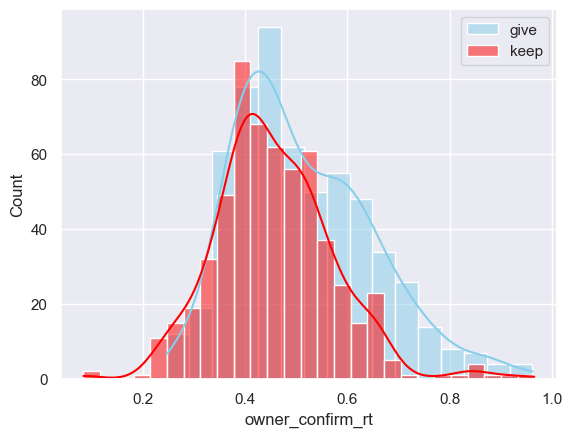

In [35]:
# Histogram of response times
sns.set_theme(style="darkgrid")

sns.histplot(data=data[data['owner_confirm_keys'] == 'g'], x="owner_confirm_rt", color="skyblue", label="give", kde=True)
sns.histplot(data=data[data['owner_confirm_keys'] == 'k'], x="owner_confirm_rt", color="red", label="keep", kde=True)

plt.legend() 
plt.show()

### Boxplot per condition group

<Axes: xlabel='identifier_chooser_owner_value_corr', ylabel='owner_confirm_rt'>

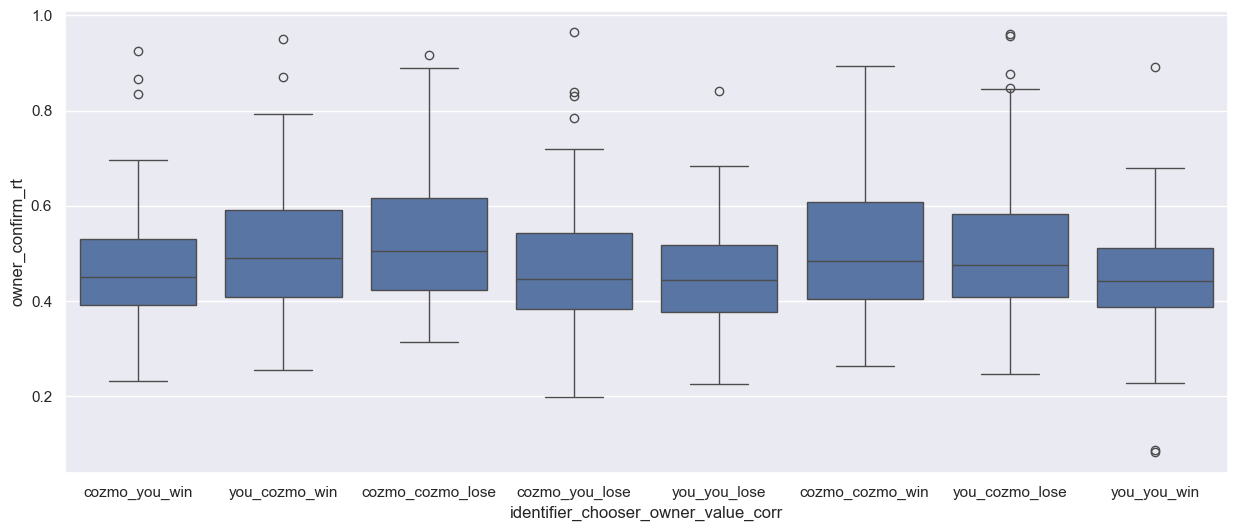

In [36]:
# Reaction time per condition group 
#TODO:change to violin plot when more data is available https://python-graph-gallery.com/39-hidden-data-under-boxplot/
plt.figure(figsize=(15, 6)) 
sns.boxplot( x=data["identifier_chooser_owner_value_corr"], y=data["owner_confirm_rt"] )

### Response time over duration of experiment

<Axes: xlabel='trial_index_within_participant', ylabel='owner_confirm_rt'>

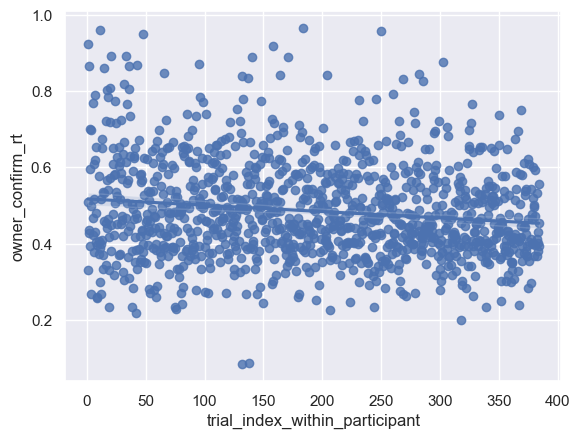

In [37]:
# how does reaction time develope over time? learning effects? do get people faster? 
# TODO: add give keep group info, or avoid overplotting https://python-graph-gallery.com/134-how-to-avoid-overplotting-with-python/ 
sns.regplot(x=data["trial_index_within_participant"], y=data["owner_confirm_rt"])

### Analysis related to handedness

Is there any relation between the handedness of participants and their choices of colors or response times?

In [38]:
# Do people prefer one choice when deciding for color? E.g., do right handed people rather choose with 'k' than 'g' when selecting one color
choice_loaction_by_handedness = data[data['chooser'] == 'you']
choice_loaction_by_handedness = choice_loaction_by_handedness.groupby(['participant', 'choice_location']).agg(
    choice_location_count=('choice_location', 'count')).reset_index()

# Merge handedenss of participants
choice_loaction_by_handedness = choice_loaction_by_handedness.merge(survey_data[['participant', 'handedness']], on='participant', how='left')

In [39]:
# Is the reaction time of outcome attribution related to handedness and answer key? E.g., are right handed people faster responding to 'keep' than 'give'
rt_by_confirm_keys = data.groupby(['participant', 'owner_confirm_keys']).agg(
    average_response_time=('owner_confirm_rt', 'mean'),
    median_response_time=('owner_confirm_rt', 'median')).reset_index()

# Merge handedenss of participants
rt_by_confirm_keys = rt_by_confirm_keys.merge(survey_data[['participant', 'handedness']], on='participant', how='left')

### Extra

In [49]:
# Are particpant faster when two times using the same key? e.g. first choose right square or confirm right square and proceed with keep (which is again the right key)?
# TODO: it would probably make sense to sort out wrong answers

# Select subset from data
subset = data.loc[:, ['participant', 'trial_index_within_participant', 'choice_location', 'owner_confirm_keys', 'owner_confirm_rt']].copy()

# Create identifier column: location_decision_owner_same = True / False
subset.loc[:, 'location_decision_owner_same'] = (
    ((subset['choice_location'] == 'left') & (subset['owner_confirm_keys'] == 'g')) |
    ((subset['choice_location'] == 'right') & (subset['owner_confirm_keys'] == 'k'))
)

# Aggregate owner_confirm_rt
subset.groupby(['location_decision_owner_same']).agg(average_response_time=('owner_confirm_rt', 'mean'))

,average_response_time
location_decision_owner_same,
False,0.490767
True,0.479914


In [40]:
# is it easier to give when cozmo anyways has a lower balance than have?
# Als variable anschauen wie viel gewinn oder Verlust Cozmo schon hatte.